In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split,cross_validate

import pandas as pd 
print(tf.__version__)

df = pd.read_excel('/content/Test_dataset.xlsx')
df.set_index('Date', inplace=True)
print(df)

# df.info()
# split_time = 420

Y_colname = ['MA5_f']
# X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
# X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_colname = ['Target', '1)철광석-중국', '4)철스크랩-터키수입가', '5)WTI', '5)BSI-해운지수', '2)중국-Flat재고', '3)중국-판재+롱재고', '4)중국-석탄내수', 
             '1)열연-미국', '1)열연-뭄바이', '1)열연-북유럽', '1)열연-한국', '1)GI-상해', '1)GI-미국']

import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

Dataset = df[[x for x in df.columns if x in X_colname+Y_colname]]
Dataset = Dataset.dropna(axis=0)  # 데이터 없는거 지우기 (앞부분)
print(Dataset)

#칼럼 순서 바꾸기 - 예측 값을 끝으로 보냄
col1=Dataset.columns[0:1].to_list()
col2=Dataset.columns[1:2].to_list()
col3=Dataset.columns[2:].to_list()
new_col=col1+col3+col2
Dataset=Dataset[new_col]

print(Dataset)

#split_time = 437

2.8.0
            index  Target  shift_down  week    MA5  MA5_f     w_inc  w_inc_UD  \
Date                                                                            
2014-01-08      6   525.0       525.0     2  525.0  525.0  0.000000         1   
2014-01-09      7   525.0       525.0     3  525.0  525.0  0.000000         1   
2014-01-10      8   525.0       525.0     4  525.0  525.0  0.000000         1   
2014-01-13     11   525.0       525.0     0  525.0  525.0  0.000000         1   
2014-01-14     12   525.0       525.0     1  525.0  525.0  0.000000         1   
...           ...     ...         ...   ...    ...    ...       ...       ...   
2022-01-26   2483   765.0       762.0     2  760.0  775.6  1.385621         1   
2022-01-27   2484   770.0       765.0     3  762.8  777.0  0.909091         1   
2022-01-28   2485   777.0       770.0     4  766.6  777.6  0.077220         1   
2022-01-31   2488   777.0       777.0     0  770.2  780.2  0.411840         1   
2022-02-01   2489   77

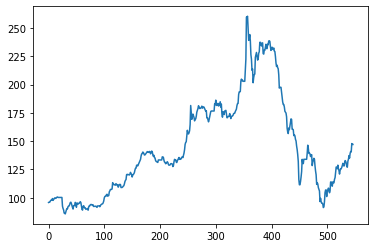

(547, 15)


In [4]:
xy= np.array(Dataset)
#print(xy[:,1])

#%matplotlib notebook
plt.plot(xy[:,1]) # 전체 종가
plt.show()
print(xy.shape)



In [88]:
#from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()
#scale_cols = ['시가', '고가', '저가', '종가', '거래량']


# 정규화 함수 
def MinMaxScaler(data1, data2):
    denom = np.max(data1,0)-np.min(data1,0)
    nume = data2-np.min(data1,0)
    return nume/denom

# 정규화 되돌리기 함수 
def back_MinMax(data,value):
    diff = np.max(data,0)-np.min(data,0)
    back = value * diff + np.min(data,0)
    return back 


trainSize = int(len(Dataset)*0.8)
trainSet = Dataset[0:trainSize]
testSet = Dataset[trainSize:]

train = MinMaxScaler(trainSet, trainSet)
test = MinMaxScaler(trainSet, testSet)



#df_scaled = scaler.fit_transform(Dataset)

#df_scaled = pd.DataFrame(df_scaled)
#df_scaled.columns = Dataset.columns

#print(df_scaled)
#print(Dataset)

In [89]:
#Dataset 구분 : Train 비율 80%, Test 비율 20%
#trainSize = int(len(xy)*0.8)

#train = df_scaled[0:trainSize]
#test = df_scaled[trainSize:]

#과거 20일을 기준으로 그 다음날의 데이터를 예측
def make_dataset(data, label, window_size=10):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size-1]))
    return np.array(feature_list), np.array(label_list)

  

In [90]:
# feature 와 label 정의
feature_cols = X_colname
label_cols = Y_colname

train_feature = train[feature_cols]
train_label = train[label_cols]

test_feature = test[feature_cols]
test_label = test[label_cols]


# train dataset
train_feature, train_label = make_dataset(train_feature, train_label)

# train, validation set 생성
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape
# ((333, 20, 14), (84, 20, 14))

# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label)
test_feature.shape, test_label.shape
# ((90, 20, 14), (90, 1))

((100, 10, 14), (100, 1))

In [104]:
# Keras를 활용한 LSTM 모델 생성

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Dropout

#model = Sequential()
#model.add(LSTM(16, 
#               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
#               activation='relu', 
#               return_sequences=False)
#          )
#model.add(Dense(1))

model = keras.Sequential()

model.add(layers.LSTM(units=32, return_sequences=True, 
                           activation='relu',
                           input_shape=(train_feature.shape[1], train_feature.shape[2])))


model.add(layers.LSTM(16))
model.add(Dropout(0.5))

model.add(layers.Dense(16))
model.add(layers.Dense(1))


model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)
#filename = os.path.join(model_path, 'tmp_checkpoint.h5')
#checkpoint = ModelCheckpoint(model, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=300, 
                    batch_size=8,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop])

# 예측
pred = model.predict(test_feature)



Epoch 1/300
43/43 [==============================] - 5s 26ms/step - loss: 0.0657 - mae: 0.1768 - val_loss: 0.0034 - val_mae: 0.0403
Epoch 2/300
43/43 [==============================] - 0s 11ms/step - loss: 0.0232 - mae: 0.1041 - val_loss: 0.0036 - val_mae: 0.0376
Epoch 3/300
43/43 [==============================] - 0s 11ms/step - loss: 0.0146 - mae: 0.0816 - val_loss: 0.0031 - val_mae: 0.0404
Epoch 4/300
43/43 [==============================] - 0s 11ms/step - loss: 0.0174 - mae: 0.0860 - val_loss: 0.0056 - val_mae: 0.0464
Epoch 5/300
43/43 [==============================] - 1s 12ms/step - loss: 0.0138 - mae: 0.0744 - val_loss: 0.0033 - val_mae: 0.0465
Epoch 6/300
43/43 [==============================] - 0s 11ms/step - loss: 0.0134 - mae: 0.0797 - val_loss: 0.0039 - val_mae: 0.0396
Epoch 7/300
43/43 [==============================] - 0s 11ms/step - loss: 0.0102 - mae: 0.0679 - val_loss: 0.0018 - val_mae: 0.0315
Epoch 8/300
43/43 [==============================] - 0s 11ms/step - loss: 0.

In [105]:
# 모델 테스트 
res = model.evaluate(test_feature, test_label, batch_size=16)
print("loss",res[0],"mae",res[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.0171 - mae: 0.1007
loss 0.017104053869843483 mae 0.10071907192468643


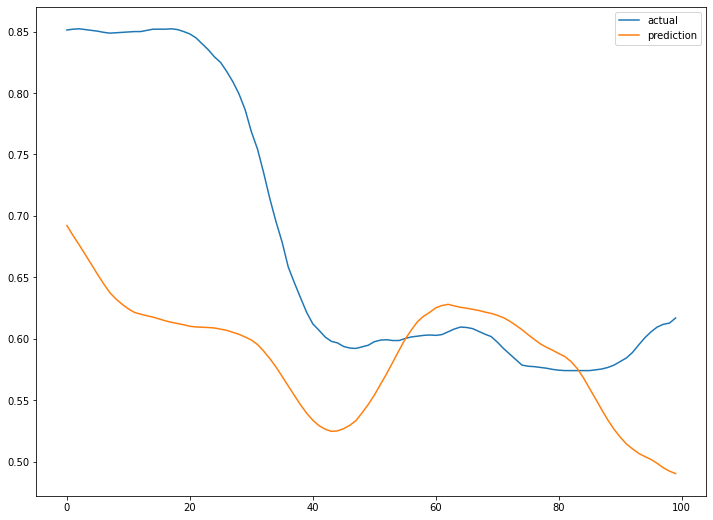

In [106]:
#실제데이터와 예측한 데이터 시각화
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

(100, 1)
(100, 1)


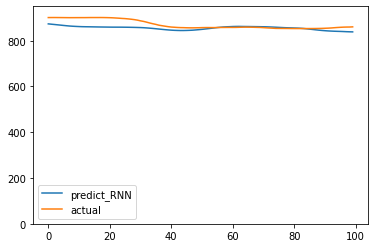

In [110]:
# 원래 값으로 되돌리기 
predict1 = back_MinMax(xy[trainSize-10:,[-1]], pred)
actual = back_MinMax(xy[trainSize-10:,[-1]], test_label)
#print("예측값",predict1)
#print("실제값",actual)

#print("Evaluate : {}".format(np.average((predict - actual)**2)))

print(predict1.shape)
print(actual.shape)

 
#%matplotlib notebook
#plt.figure()
plt.plot(predict1, label = "predict_LSTM")
plt.plot(actual,label = "actual")
plt.legend()
plt.ylim([0, 950])
plt.show()

In [108]:
MAE = abs(actual - predict1).mean()
MSE = ((actual - predict1)**2).mean()
MAPE = (abs(actual - predict1)/actual*100).mean()

pd.options.display.float_format = '{:,.2f}'.format
display(pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T)

,MAE,MSE,MAPE
Score,17.44,513.09,1.97


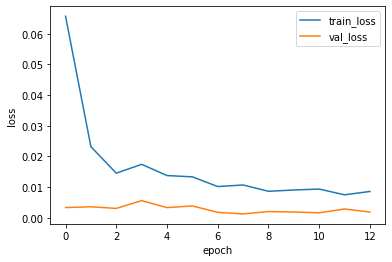

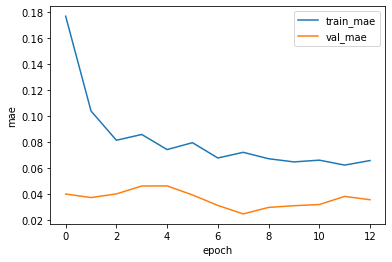

In [109]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train_mae', 'val_mae'])
plt.show()